In [1]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import numpy as np
import seaborn as sns

In [2]:
test_video = 'marker_vid.mp4'
print(os.path.isfile(test_video))

True


In [3]:
def extract_nth_frame(video_path, n, output_path=None, flip=False):
    cap = cv2.VideoCapture(video_path)
    if n < 1 or n > int(cap.get(cv2.CAP_PROP_FRAME_COUNT)): return None

    for count in range(n-1):
       ret, _ = cap.read()
       if not ret or not cap.isOpened(): break

    ret, frame = cap.read()
    cap.release()
    if not ret: return None

    if flip: frame = cv2.flip(frame, 0)
    if output_path: cv2.imwrite(output_path, frame)
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

In [4]:
n = 100
test_frame = extract_nth_frame(test_video, n)

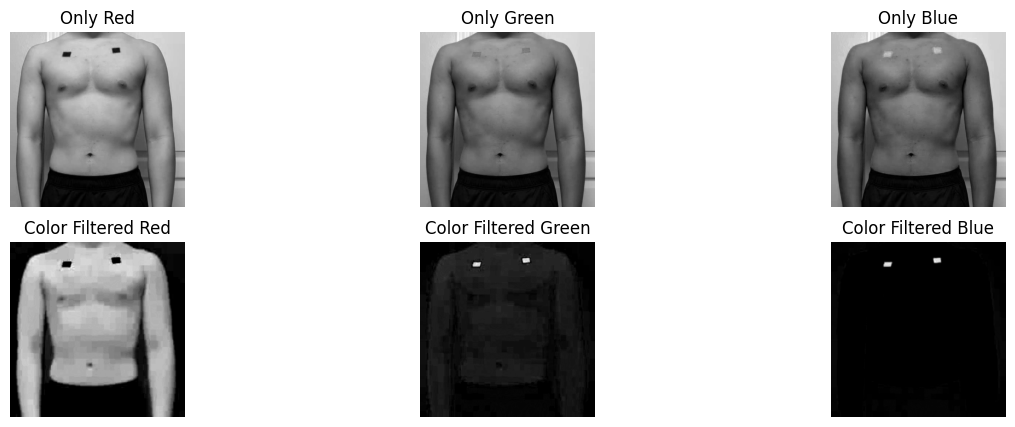

In [5]:
fig, ax = plt.subplots(2, 3, figsize=(15, 5))
for i, a in enumerate(ax[0]):
    a.axis('off')
    a.set_title(f'Only {["Red", "Green", "Blue"][i]}')
    a.imshow(test_frame[:, :, i], cmap='gray')
for i, a in enumerate(ax[1]):
    a.axis('off')
    a.set_title(f'Color Filtered {["Red", "Green", "Blue"][i]}')
    frame = test_frame[:, :, i] - np.min(test_frame, axis=-1)
    a.imshow(frame, cmap='gray')

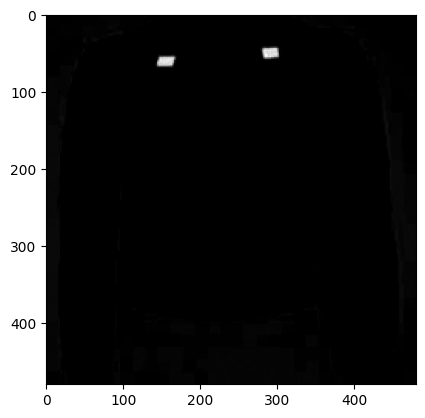

In [6]:
tf_kp = test_frame[:, :, 2] - np.min(test_frame, axis=-1)
plt.figure()
plt.imshow(tf_kp, cmap='gray')
plt.show()

In [7]:
keypoints = cv2.goodFeaturesToTrack(tf_kp, mask=None, 
                                    maxCorners=100,
                                    qualityLevel=0.1,
                                    minDistance=5)
kp1 = np.squeeze(keypoints)
print(f'{len(kp1)} points found')

8 points found


10 points found


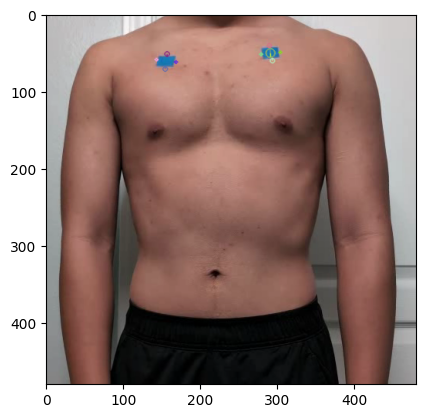

In [8]:
sift = cv2.SIFT_create()
kp_sift = sift.detect(tf_kp, mask=None)
kp2 = np.array([kp.pt for kp in kp_sift])
print(f'{len(kp2)} points found')

sift_out = test_frame.copy()
sift_out = cv2.drawKeypoints(test_frame, kp_sift, sift_out,
                             flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure()
plt.imshow(sift_out)
plt.show()

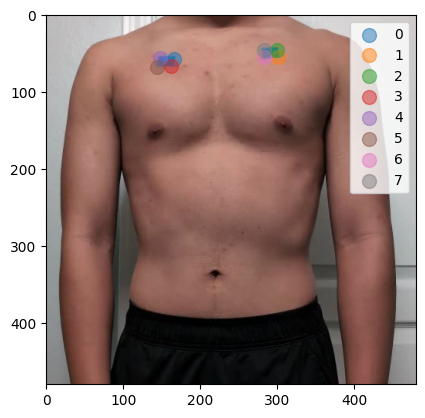

In [9]:
plt.figure()
plt.imshow(test_frame)
for i, (x, y) in enumerate(kp1):
    plt.scatter(x, y, s=100, alpha=0.5, label=str(i))
plt.legend()
plt.show()

In [10]:
# optical flow motion track
def kp_preprocess(frame):
    return frame[:, :, 0] - np.min(frame, axis=-1)
def get_kp(frame):
    keypoints = cv2.goodFeaturesToTrack(frame, mask=None, 
                                        maxCorners=100,
                                        qualityLevel=0.1,
                                        minDistance=5)
    return keypoints
def stabilize_video(video_path):
  # Open the video capture
  cap = cv2.VideoCapture(video_path)

  # Define parameters
  lk_params = dict(
    winSize=(15, 15), 
    maxLevel=2, 
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
  RESET_INDEX = 0 # number of frames before resetting transform matrix
  SAVE_VIDEO = True # save video vs display only

  # Define variables for tracking
  ret, prev_frame = cap.read()
  prev_kp_frame = kp_preprocess(prev_frame)
  prev_pts = get_kp(prev_kp_frame)

  # Lists to store tracked points and motion vectors
  pts = [prev_pts]
  mv = [np.eye(3)]
  orig_frames = []
  stabilized_frames = []
  last_transform = np.eye(3)

  while True:
    ret, frame = cap.read()
    if not ret:
      break

    kp_frame = kp_preprocess(frame)

    # Calculate optical flow
    curr_pts, status, err = cv2.calcOpticalFlowPyrLK(
        prev_kp_frame, kp_frame, prev_pts, 
        np.array([]))

    # Filter good features
    good_old = prev_pts[status == 1]
    good_new = curr_pts[status == 1]

    # Estimate motion from good features
    if len(good_old) >= 3:
      M, mask = cv2.estimateAffine2D(good_old, good_new)
      if M is not None:
        M = np.vstack([M, [0, 0, 1]]) # Convert to 3x3 matrix
      else:
        M = mv[-1] # Use last motion vector
    else:
      M = mv[-1]
    mv.append(M)

    # Update for next iteration
    prev_kp_frame = kp_frame.copy()
    prev_pts = good_new.reshape(-1, 1, 2)

    # Stabilize frame (reverse motion)
    h, w = frame.shape[:2]
    # avg_mv = np.mean(mv, axis=0)
    transform = M @ last_transform
    # reset transformation as needed
    if RESET_INDEX and len(mv) % RESET_INDEX == 0:
      transform = np.eye(3)
      mv = [transform]
    last_transform = transform
    inv_M = cv2.invertAffineTransform(transform[:2])
    stabilized_frame = cv2.warpAffine(frame, inv_M, (w, h))

    if SAVE_VIDEO:
      stabilized_frames.append(stabilized_frame)
      orig_frames.append(frame)
    else:
      # Display original and stabilized frame side-by-side
      cv2.imshow('Video', np.hstack([frame, stabilized_frame, cv2.absdiff(frame, stabilized_frame)]))

    # Exit on 'q' press
    if cv2.waitKey(1) & 0xFF == ord('q'):
      break

  # Release resources
  cap.release()
  cv2.destroyAllWindows()

  return orig_frames, stabilized_frames

In [11]:
original_frames, stabilized_frames = stabilize_video(test_video)

In [12]:
 # crop image to only focus on the chest
cropped_frames = [frame[50:350, 100:400] for frame in stabilized_frames]
cv2.imshow('image', cropped_frames[0])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [13]:
# smooth the video using moving average
def smooth_video(frames, window=5):
  smoothed_frames = []
  for i in range(len(frames)):
    smoothed_frame = np.mean(frames[max(0, i-window):i+1], axis=0)
    smoothed_frames.append(smoothed_frame)
  return smoothed_frames

In [14]:
smoothed_frames = smooth_video(cropped_frames, window=5)

In [15]:
if len(cropped_frames) != 0:
    # save video
    writer = cv2.VideoWriter('stabilized_video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30, (smoothed_frames[0].shape[1], smoothed_frames[0].shape[0]))
    for frame in smoothed_frames:
        writer.write(cv2.convertScaleAbs(frame))
    writer.release()

In [16]:
# crop orginal video to only focus on the chest
cropped_frames = [frame[50:350, 100:400] for frame in original_frames]
cv2.imshow('image', cropped_frames[0])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [66]:
def draw_optical_flow(frame, prev_pts, curr_pts, mask):
    color = np.random.randint(0, 255, (100, 3))
    
    # Draw the tracks
    for i, (new, old) in enumerate(zip(curr_pts, prev_pts)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
        frame = cv2.circle(frame, (int(a), int(b)), 5, color[i].tolist(), -1)
    
    return cv2.add(frame, mask)

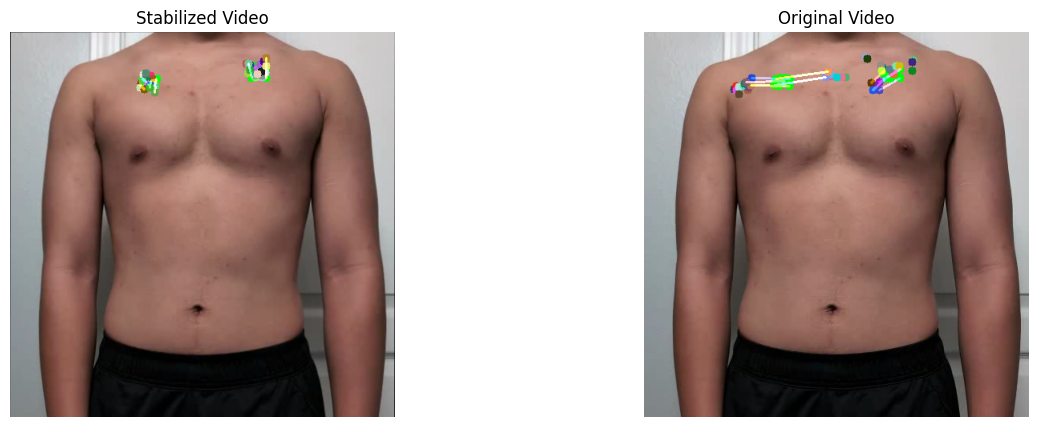

In [77]:
# draw optical flow using 10 frames for both original and stabilized video
n = 2
FRAME_NUM = 0
prev_frame = stabilized_frames[FRAME_NUM]
prev_kp_frame = kp_preprocess(prev_frame)
prev_pts = get_kp(prev_kp_frame)

# side by side comparison
prev_frame_og = original_frames[FRAME_NUM]
prev_kp_frame_og = kp_preprocess(prev_frame_og)
prev_pts_og = get_kp(prev_kp_frame_og)

mask = np.zeros_like(prev_frame)
mask_og = np.zeros_like(prev_frame_og)

for i in range(FRAME_NUM+1, FRAME_NUM+n):
    curr_frame = stabilized_frames[i]
    curr_kp_frame = kp_preprocess(curr_frame)
    curr_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_kp_frame, curr_kp_frame, prev_pts, None)
    
    curr_frame_og = original_frames[i]
    curr_kp_frame_og = kp_preprocess(curr_frame_og)
    curr_pts_og, status_og, err_og = cv2.calcOpticalFlowPyrLK(prev_kp_frame_og, curr_kp_frame_og, prev_pts_og, None)
    
    mask = draw_optical_flow(curr_frame, prev_pts[status == 1], curr_pts[status == 1], mask)
    mask_og = draw_optical_flow(curr_frame_og, prev_pts_og[status_og == 1], curr_pts_og[status_og == 1], mask_og)
    
    prev_kp_frame = curr_kp_frame.copy()
    prev_pts = curr_pts[status == 1].reshape(-1, 1, 2)
    
    prev_kp_frame_og = curr_kp_frame_og.copy()
    prev_pts_og = curr_pts_og[status_og == 1].reshape(-1, 1, 2)

# convert to RGB
frame = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
frame_og = cv2.cvtColor(mask_og, cv2.COLOR_BGR2RGB)

# create subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
ax[0].imshow(frame)
ax[0].set_title('Stabilized Video')
ax[0].axis('off')
ax[1].imshow(frame_og)
ax[1].set_title('Original Video')
ax[1].axis('off')
plt.show()